In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
%matplotlib inline

In [2]:
import tensorflow
print (tensorflow.__version__)

2.4.0


In [12]:
from google.colab import drive

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [13]:
!wget http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/maps.tar.gz

--2020-12-22 04:40:45--  http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/maps.tar.gz
Resolving efrosgans.eecs.berkeley.edu (efrosgans.eecs.berkeley.edu)... 128.32.189.73
Connecting to efrosgans.eecs.berkeley.edu (efrosgans.eecs.berkeley.edu)|128.32.189.73|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 250242400 (239M) [application/x-gzip]
Saving to: ‘maps.tar.gz’

maps.tar.gz         100%[===================>] 238.65M   525KB/s    in 2m 47s  

2020-12-22 04:43:32 (1.43 MB/s) - ‘maps.tar.gz’ saved [250242400/250242400]



In [15]:
!tar -zxf maps.tar.gz

In [16]:
!ls

gdrive	maps  maps.tar.gz  sample_data


In [21]:
import glob
train_files = glob.glob('maps/train/*.jpg')
test_files = glob.glob('maps/val/*.jpg')

In [22]:
len(train_files), len(test_files)

(1096, 1098)

In [25]:
import cv2
for file in train_files[:10]:
    map = cv2.imread(file)
    print (map.shape)

(600, 1200, 3)
(600, 1200, 3)
(600, 1200, 3)
(600, 1200, 3)
(600, 1200, 3)
(600, 1200, 3)
(600, 1200, 3)
(600, 1200, 3)
(600, 1200, 3)
(600, 1200, 3)


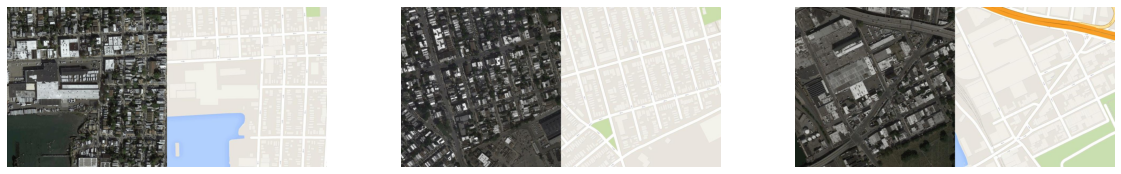

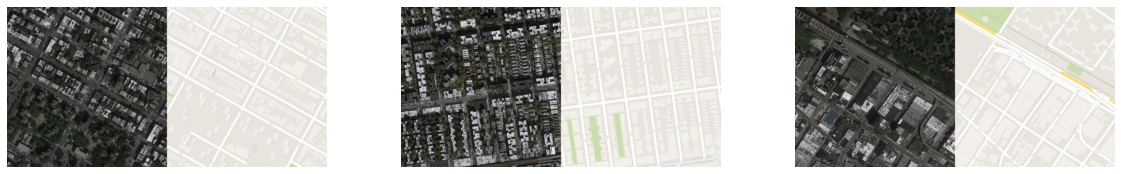

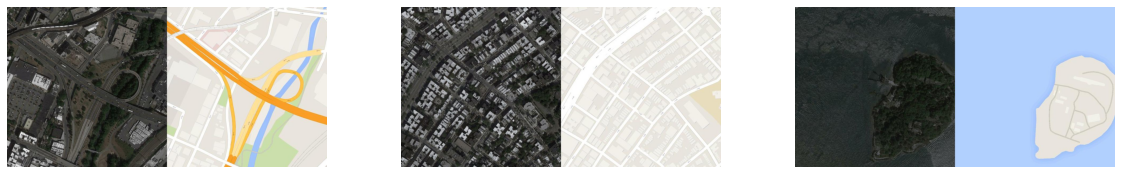

In [31]:
for k in range(3):
    plt.figure(figsize=(20, 10))
    for j in range(3):
        file = np.random.choice(train_files)
        map = cv2.imread(file)
        map = cv2.cvtColor(map, cv2.COLOR_BGR2RGB)
        plt.subplot(330 + 1 + j)
        plt.imshow(map)
        plt.axis('off')
        #plt.title(trainY[i])
    plt.show()

Input Images


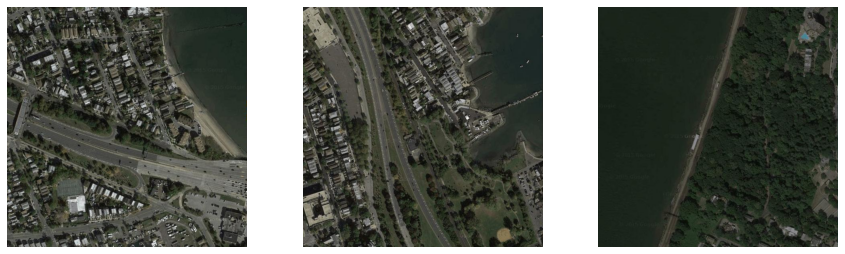

Output Images


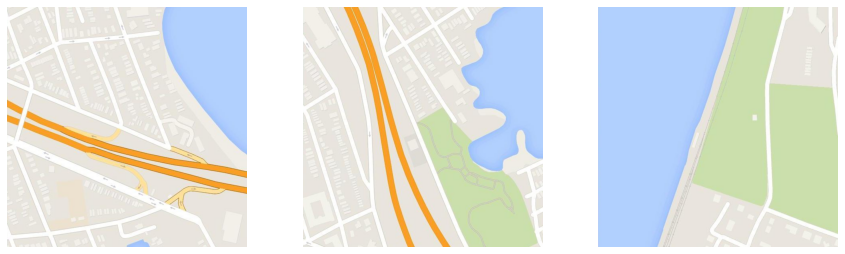

In [37]:
maps = []
for j in range(3):
    file = np.random.choice(train_files)
    map = cv2.imread(file)
    map = cv2.cvtColor(map, cv2.COLOR_BGR2RGB)
    maps.append(map)

print ('Input Images')
plt.figure(figsize=(15, 15))
for j, map in enumerate(maps):
    map1 = map[:, :map.shape[1]//2]
    plt.subplot(330 + 1 + j)
    plt.imshow(map1)
    plt.axis('off')
    #plt.title(trainY[i])
plt.show()

print ('Output Images')
plt.figure(figsize=(15, 15))
for j, map in enumerate(maps):
    map2 = map[:, map.shape[1]//2:]
    plt.subplot(330 + 1 + j)
    plt.imshow(map2)
    plt.axis('off')
    #plt.title(trainY[i])
plt.show()

# Generator Model (U-Net Like)

In [38]:
def encoder_layer(input_layer, filters, bn=True):
    x = tensorflow.keras.layers.Conv2D(filters, kernel_size=(4,4), strides=(2,2), padding='same')(input_layer)
    x = tensorflow.keras.layers.LeakyReLU(alpha=0.2)(x)
    if bn:
        x = tensorflow.keras.layers.BatchNormalization(momentum=0.8)(x)
    return x

def decoder_layer(input_layer, skip_input, filters):
    #x = tensorflow.keras.layers.UpSampling2D(size=2)(input_layer)
    x = tensorflow.keras.layers.Conv2DTranspose(filters, kernel_size=(4,4), strides=(2,2), padding='same')(input_layer)
    x = tensorflow.keras.layers.Activation('relu')(x)
    x = tensorflow.keras.layers.BatchNormalization(momentum=0.8)(x)
    x = tensorflow.keras.layers.Concatenate()([x, skip_input])
    return x

In [40]:
source_image_input = tensorflow.keras.layers.Input(shape=(256, 256, 3))

e1 = encoder_layer(source_image_input, 64, bn=False)#64
e2 = encoder_layer(e1, 64)#128
e3 = encoder_layer(e2, 64)#256
e4 = encoder_layer(e3, 128)#512
e5 = encoder_layer(e4, 128)#512
e6 = encoder_layer(e5, 128)#512
e7 = encoder_layer(e6, 128)#512

bottle_neck = tensorflow.keras.layers.Conv2D(128, (4,4), strides=(2,2), padding='same')(e7)
b = tensorflow.keras.layers.Activation('relu')(bottle_neck)

d1 = decoder_layer(b, e7, 128)#512
d2 = decoder_layer(d1, e6, 128)#512
d3 = decoder_layer(d2, e5, 128)#512
d4 = decoder_layer(d3, e4, 128)#512
d5 = decoder_layer(d4, e3, 64)#256
d6 = decoder_layer(d5, e2, 64)#128
d7 = decoder_layer(d6, e1, 64)#64

decoded = tensorflow.keras.layers.Conv2DTranspose(3, kernel_size=(4,4), strides=(2,2), padding='same')(d7)
translated_image = tensorflow.keras.layers.Activation('tanh')(decoded)

generator_network = tensorflow.keras.models.Model(inputs=source_image_input, outputs=translated_image)
print (generator_network.summary())

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_8 (Conv2D)               (None, 128, 128, 64) 3136        input_2[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu_7 (LeakyReLU)       (None, 128, 128, 64) 0           conv2d_8[0][0]                   
__________________________________________________________________________________________________
conv2d_9 (Conv2D)               (None, 64, 64, 64)   65600       leaky_re_lu_7[0][0]              
____________________________________________________________________________________________

# Discriminator Network

In [41]:
def my_conv_layer(input_layer, filters, bn=True):
    x = tensorflow.keras.layers.Conv2D(filters, kernel_size=(4,4), strides=(2,2), padding='same')(input_layer)
    x = tensorflow.keras.layers.LeakyReLU(alpha=0.2)(x)
    if bn:
        x = tensorflow.keras.layers.BatchNormalization(momentum=0.8)(x)
    return x

In [42]:
source_image_input = tensorflow.keras.layers.Input(shape=(256, 256, 3))
target_image_input = tensorflow.keras.layers.Input(shape=(256, 256, 3))

combined = tensorflow.keras.layers.Concatenate(axis=-1)([source_image_input, target_image_input])

x = my_conv_layer(combined, 64, bn=False)#64
x = my_conv_layer(x, 64)#128
x = my_conv_layer(x, 128)#256
x = my_conv_layer(x, 256)#512

patch_features = tensorflow.keras.layers.Conv2D(1, kernel_size=(4,4), strides=(1,1), padding='same')(x)

discriminator_network = tensorflow.keras.models.Model(inputs=[source_image_input, target_image_input], outputs=patch_features)
print (discriminator_network.summary())

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
concatenate_14 (Concatenate)    (None, 256, 256, 6)  0           input_3[0][0]                    
                                                                 input_4[0][0]                    
__________________________________________________________________________________________________
conv2d_16 (Conv2D)              (None, 128, 128, 64) 6208        concatenate_14[0][0]       

In [43]:
adam_optimizer = tensorflow.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
discriminator_network.compile(loss='mse', optimizer=adam_optimizer, metrics=['accuracy'])

# pix2pix

In [44]:
discriminator_network.trainable=False

g_output = generator_network(source_image_input)
d_output = discriminator_network([source_image_input, g_output])

pix2pix = tensorflow.keras.models.Model(inputs=source_image_input, outputs=[d_output, g_output])
pix2pix.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
model_1 (Functional)            (None, 256, 256, 3)  3686147     input_3[0][0]                    
__________________________________________________________________________________________________
model_2 (Functional)            (None, 16, 16, 1)    733441      input_3[0][0]                    
                                                                 model_1[0][0]                    
Total params: 4,419,588
Trainable params: 3,683,459
Non-trainable params: 736,129
__________________________________________________________________________________________________


# Compiling Models

In [45]:
pix2pix.compile(loss=['mse', 'mae'], optimizer=adam_optimizer, loss_weights=[1, 100])

# Define Data Generators

In [70]:
def get_predictions(input_sample, generator_network):
    input_sample = np.expand_dims(input_sample, axis=0)
    output_sample = generator_network.predict_on_batch(input_sample)
    return output_sample

def get_generated_samples(generator_network, maps_input):
    generated_samples = generator_network.predict_on_batch(maps_input)
    return generated_samples

def get_map_samples(batch_size):
    random_files = np.random.choice(train_files, size=batch_size)
    maps_input = []
    maps_output = []
    for file in random_files:
        map = cv2.imread(file)
        map = cv2.cvtColor(map, cv2.COLOR_BGR2RGB)
        map1 = map[:, :map.shape[1]//2]
        map2 = map[:, map.shape[1]//2:]
        map1 = cv2.resize(map1, (256, 256))
        map2 = cv2.resize(map2, (256, 256))
        maps_input.append((map1-127.5)/127.5)
        maps_output.append((map2-127.5)/127.5)
    maps_input = np.array(maps_input)
    maps_output = np.array(maps_output)
    return maps_input, maps_output

def show_generator_results(generator_network):
    maps = []
    for j in range(3):
        file = np.random.choice(test_files)
        map = cv2.imread(file)
        map = cv2.cvtColor(map, cv2.COLOR_BGR2RGB)
        maps.append(map)

    print ('Input Images')
    plt.figure(figsize=(15, 15))
    for j, map in enumerate(maps):
        map1 = map[:, :map.shape[1]//2]
        map1 = cv2.resize(map1, (256, 256))
        plt.subplot(330 + 1 + j)
        plt.imshow(map1)
        plt.axis('off')
        #plt.title(trainY[i])
    plt.show()

    print ('Predicted Output Images')
    plt.figure(figsize=(15, 15))
    for j, map in enumerate(maps):
        map1 = map[:, :map.shape[1]//2]
        map1 = cv2.resize(map1, (256, 256))
        map1 = (map1-127.5)/127.5
        output = get_predictions(map1, generator_network)[0]
        output = (output+1.0)/2.0
        plt.subplot(330 + 1 + j)
        plt.imshow(output)
        plt.axis('off')
        #plt.title(trainY[i])
    plt.show()

    print ('Real Output Images')
    plt.figure(figsize=(15, 15))
    for j, map in enumerate(maps):
        map2 = map[:, map.shape[1]//2:]
        map2 = cv2.resize(map2, (256, 256))
        plt.subplot(330 + 1 + j)
        plt.imshow(map2)
        plt.axis('off')
        #plt.title(trainY[i])
    plt.show()

# Training GAN

In [71]:
len(train_files)

1096

Input Images


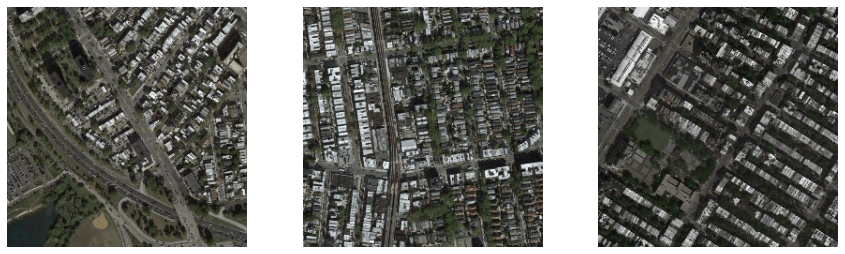

Predicted Output Images


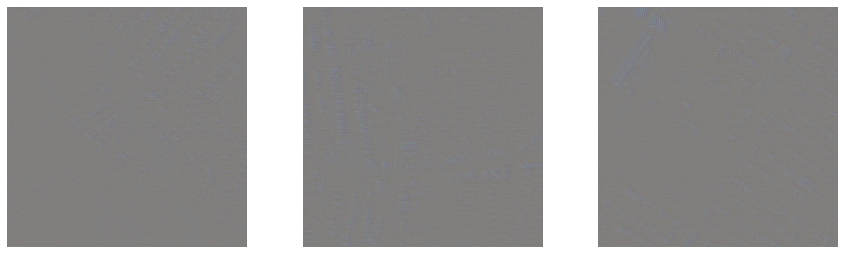

Real Output Images


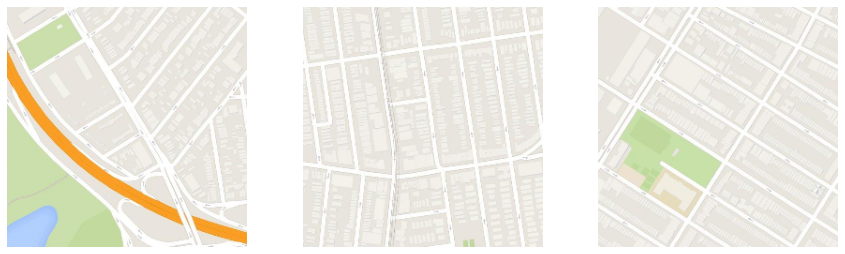

NameError: ignored

In [72]:
epochs = 500
batch_size = 100
steps = 11

for i in range(0, epochs):
    if (i%10 == 0):
        op = show_generator_results(generator_network)
    for j in range(steps):
        maps_input, maps_output = get_map_samples(batch_size=batch_size//2)
        generated_maps_output = get_generated_samples(generator_network, maps_input)

        fake_patch = np.zeros((batch_size//2, 16, 16, 1))
        real_patch = np.ones((batch_size//2, 16, 16, 1))
        
        # Updating Discriminator weights
        discriminator_network.trainable=True
        loss_d1 = discriminator_network.train_on_batch([maps_input, maps_output], real_patch)
        loss_d2 = discriminator_network.train_on_batch([maps_input, generated_maps_output], fake_patch)
        
        loss_d = (np.add(loss_d1, loss_d2))/2.0
        
        
        maps_input, maps_output = get_map_samples(batch_size=batch_size)
        
        # Make the Discriminator belive that these are real samples and calculate loss to train the generator
        real_patch = np.ones((batch_size, 16, 16, 1))
        
        # Updating Generator weights
        discriminator_network.trainable=False
        loss_g, _, _ = pix2pix.train_on_batch(maps_input, [real_patch, maps_output])
        
        if j%10 == 0:
            print ("Epoch:%.0f, Step:%.0f, D-Loss:%.3f, D-Acc:%.3f, G-Loss:%.3f"%(i,j,loss_d[0],loss_d[1]*100,loss_g))   